### Distributed DeepRacer RL training with SageMaker and RoboMaker

---
## Introduction


In this notebook, we will train a fully autonomous 1/18th scale race car using reinforcement learning using Amazon SageMaker RL and AWS RoboMaker's 3D driving simulator. [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) is a service that makes it easy for developers to develop, test, and deploy robotics applications.  

This notebook provides a jailbreak experience of [AWS DeepRacer](https://console.aws.amazon.com/deepracer/home#welcome), giving us more control over the training/simulation process and RL algorithm tuning.

![Training in Action](./DeepRacerCar.png)


---
## How it works?  

![How training works](./training.png)

The reinforcement learning agent (i.e. our autonomous car) learns to drive by interacting with its environment, e.g., the track, by taking an action in a given state to maximize the expected reward. The agent learns the optimal plan of actions in training by trial-and-error through repeated episodes.  
  
The figure above shows an example of distributed RL training across SageMaker and two RoboMaker simulation envrionments that perform the **rollouts** - execute a fixed number of episodes using the current model or policy. The rollouts collect agent experiences (state-transition tuples) and share this data with SageMaker for training. SageMaker updates the model policy which is then used to execute the next sequence of rollouts. This training loop continues until the model converges, i.e. the car learns to drive and stops going off-track. More formally, we can define the problem in terms of the following:  

1. **Objective**: Learn to drive autonomously by staying close to the center of the track.
2. **Environment**: A 3D driving simulator hosted on AWS RoboMaker.
3. **State**: The driving POV image captured by the car's head camera, as shown in the illustration above.
4. **Action**: Six discrete steering wheel positions at different angles (configurable)
5. **Reward**: Positive reward for staying close to the center line; High penalty for going off-track. This is configurable and can be made more complex (for e.g. steering penalty can be added).

## Prequisites

### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

You can run this notebook from your local machine or from a SageMaker notebook instance. In both of these scenarios, you can run the following to launch a training job on SageMaker and a simulation job on RoboMaker.

In [1]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import subprocess
import yaml

sys.path.append("common")
sys.path.append("./src")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_docker_image
from docker_utils import push as docker_push
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework
from time import gmtime, strftime
import time
from IPython.display import Markdown
from markdown_helper import *

### Define the IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use utils method `role = get_execution_role('role_name')` to create an execution role.

In [2]:
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role("sagemaker")

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

Using Sagemaker IAM role arn: 
arn:aws:iam::011113936377:role/service-role/AWSDeepRacerSageMakerAccessRole


> Please note that this notebook cannot be run in `SageMaker local mode` as the simulator is based on AWS RoboMaker service.

## Download a copy of the DeepRacer simapp

This is a docker container of the simulation application loaded into robomaker. A copy is downloaded and then some files are extracted.

In [3]:
# This is the name of the simapp that is locally created and pushed to your account ECR
local_simapp_ecr_docker_image_name = "deepracer-sim-local-notebook"
public_ecr_alias = "k1d3r4z1"

# Clean up the docker images
!if [ -n "$(docker ps -a -q)" ]; then docker rm -f $(docker ps -a -q); fi
!if [ -n "$(docker images -q)" ]; then docker rmi -f $(docker images -q); fi

!aws ecr-public get-login-password --region us-east-1 | docker login --username AWS --password-stdin public.ecr.aws

!docker pull public.ecr.aws/{public_ecr_alias}/deepracer-sim-public

!docker tag public.ecr.aws/{public_ecr_alias}/deepracer-sim-public {local_simapp_ecr_docker_image_name}

# Get docker id and container id
simapp_docker_ids = !docker images | grep deepracer-sim-public | tr -s ' '| cut -d ' ' -f 3 | head -n 1
simapp_docker_id = simapp_docker_ids[0]
simapp_container_ids = !docker run -d -t {simapp_docker_id}
simapp_container_id = simapp_container_ids[0]

# Copy all the required training related code and update the code base
!docker cp {simapp_container_id}:/opt/amazon/markov ./src/
!docker cp {simapp_container_id}:/opt/amazon/rl_coach.patch ./src/
!docker cp {simapp_container_id}:/opt/ml/code/. ./src/lib/
!rm ./src/lib/credentials #Bug in Jupyter can't handle symlinks to files w/o read perms
    
#Copy out the Robomaker 3d environment for inspection
!docker cp {simapp_container_id}:/opt/amazon/install/deepracer_simulation_environment ./src/



4e3d4a860370
Deleted: sha256:d3aeb82c0ecdcbd469050c16c9071b76bcd8b8a54f137fe57369d6f2b8d7b8cd
Deleted: sha256:f6fe55327354e8a43efa1fcb0592eefecb6bd9f61926cf23547c467097995db2
Deleted: sha256:aca41131ed52d2c39937e64e305526e3ae39839e52aa45cc3a761183bedd789c
Deleted: sha256:edd42120b2b4b31e724a9d1a9c5ce0250f9a6f42fb76a8c022591c8a0482be74
Deleted: sha256:f75bd70792e98122bc39eb3b01cdf2c373a4817147f09fb7120c173ceb490f05
Deleted: sha256:6cecb95f14d7bc188d420fee48a040c81cb1361e4231d3a7f67e107c75963998
Deleted: sha256:6e8928029672bdce4770b374bddbc5b27aa0bf4f6bb5c0f9e754e27e19b8d800
Deleted: sha256:47fe95b952d71dc2cf87da8b6cc9c65eedf0a35b5b50a2baa8901c44f2cc2a18
Untagged: ubuntu:18.04
Untagged: ubuntu@sha256:ca70a834041dd1bf16cc38dfcd24f0888ec4fa431e09f3344f354cf8d1724499
Deleted: sha256:71eaf13299f415122ad887b4592146a6b6f5e80cd69e0cd4650102fa3a99972c
Deleted: sha256:69f57fbceb1b420d7e4697e0f6514887b0805ee0059bea7d51e0a832962e74bf
Untagged: deepracer-sim-local-notebook:latest
Untagged: public.ec

703f41a2: Extracting  892.4MB/1.11GBBB

Digest: sha256:eabc75afcf6b6296b03c87ad40523bd0a5207c13be1ab2db5dbb999a142a6478A
Status: Downloaded newer image for public.ecr.aws/k1d3r4z1/deepracer-sim-public:latest
public.ecr.aws/k1d3r4z1/deepracer-sim-public:latest


### Initializing basic parameters

In [4]:
# Select the instance type
instance_type = "ml.c4.2xlarge"
# instance_type = "ml.p2.xlarge"
# instance_type = "ml.c5.4xlarge"

# Starting SageMaker session
sage_session = sagemaker.session.Session()

# Create unique job name.
job_name_prefix = "deepracer-notebook"

# Duration of job in seconds (10 minutes)
job_duration_in_seconds = 600

# AWS Region
aws_region = sage_session.boto_region_name
if aws_region not in ["us-west-2", "us-east-1", "eu-west-1"]:
    raise Exception(
        "This notebook uses RoboMaker which is available only in US East (N. Virginia),"
        "US West (Oregon) and EU (Ireland). Please switch to one of these regions."
    )

### Build Sagemaker docker image

The file ./Dockerfile contains all the packages that are installed into the docker. Instead of using the default sagemaker container, we will be using this docker container. This is a separate docker container than the one created earlier for robomaker.

In [5]:
%%time
from copy_to_sagemaker_container import (
    get_sagemaker_docker,
    copy_to_sagemaker_container,
    get_custom_image_name,
)

cpu_or_gpu = "gpu" if instance_type.startswith("ml.p") else "cpu"
repository_short_name = "sagemaker-docker-%s" % cpu_or_gpu
custom_image_name = get_custom_image_name(repository_short_name)
try:
    print("Copying files from your notebook to existing sagemaker container")
    sagemaker_docker_id = get_sagemaker_docker(repository_short_name)
    copy_to_sagemaker_container(sagemaker_docker_id, repository_short_name)
except Exception as e:
    print("Creating sagemaker container")
    docker_build_args = {
        "CPU_OR_GPU": cpu_or_gpu,
        "AWS_REGION": boto3.Session().region_name,
    }
    build_docker_image(
        repository_short_name, build_args=docker_build_args
    )


Copying files from your notebook to existing sagemaker container
docker images sagemaker-docker-cpu | sed -n 2,2p
Creating sagemaker container
Building docker image sagemaker-docker-cpu from Dockerfile
$ docker build -t sagemaker-docker-cpu -f Dockerfile . --build-arg CPU_OR_GPU=cpu --build-arg AWS_REGION=us-east-1
Sending build context to Docker daemon  1.359GB
Step 1/26 : FROM ubuntu:18.04
18.04: Pulling from library/ubuntu
a404e5416296: Pulling fs layer
a404e5416296: Verifying Checksum
a404e5416296: Download complete
a404e5416296: Pull complete
Digest: sha256:ca70a834041dd1bf16cc38dfcd24f0888ec4fa431e09f3344f354cf8d1724499
Status: Downloaded newer image for ubuntu:18.04
 ---> 71eaf13299f4
Step 2/26 : COPY ./src/markov /opt/amazon/markov
 ---> 8473cee31155
Step 3/26 : RUN apt-get update && apt-get install -y     build-essential     cmake     git     curl     vim     ca-certificates     libjpeg-dev     wget     fonts-liberation     libxss1 libappindicator1 libindicator7     xvfb     l

The following NEW packages will be installed:
  adwaita-icon-theme binutils binutils-common binutils-x86-64-linux-gnu
  build-essential ca-certificates cmake cmake-data cpp cpp-7 curl dbus
  dh-python dirmngr distro-info-data dpkg-dev fakeroot file fontconfig
  fontconfig-config fonts-liberation g++ g++-7 gcc gcc-7 gcc-7-base
  geoip-database gir1.2-glib-2.0 git git-man gnupg gnupg-l10n gnupg-utils gpg
  gpg-agent gpg-wks-client gpg-wks-server gpgconf gpgsm gtk-update-icon-cache
  hicolor-icon-theme humanity-icon-theme iproute2 krb5-locales less
  libalgorithm-diff-perl libalgorithm-diff-xs-perl libalgorithm-merge-perl
  libapparmor1 libappindicator1 libarchive13 libasan4 libasn1-8-heimdal
  libasound2 libasound2-data libassuan0 libatk1.0-0 libatk1.0-data libatm1
  libatomic1 libauthen-sasl-perl libavahi-client3 libavahi-common-data
  libavahi-common3 libbinutils libbsd0 libc-dev-bin libc6-dev libcairo2
  libcc1-0 libcilkrts5 libcroco3 libcups2 libcurl3-gnutls libcurl4
  libdata-dump-p

Get:40 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libxml2 amd64 2.9.4+dfsg1-6.1ubuntu1.7 [663 kB]
Get:41 http://archive.ubuntu.com/ubuntu bionic/main amd64 shared-mime-info amd64 1.9-2 [426 kB]
Get:42 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgdk-pixbuf2.0-common all 2.36.11-2 [4536 B]
Get:43 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgdk-pixbuf2.0-0 amd64 2.36.11-2 [165 kB]
Get:44 http://archive.ubuntu.com/ubuntu bionic/main amd64 libthai-data all 0.1.27-2 [133 kB]
Get:45 http://archive.ubuntu.com/ubuntu bionic/main amd64 libdatrie1 amd64 0.2.10-7 [17.8 kB]
Get:46 http://archive.ubuntu.com/ubuntu bionic/main amd64 libthai0 amd64 0.1.27-2 [18.0 kB]
Get:47 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libpango-1.0-0 amd64 1.40.14-1ubuntu0.1 [153 kB]
Get:48 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdbusmenu-gtk4 amd64 16.04.1+18.04.20171206-0ubuntu2 [26.9 kB]
Get:49 http://archive.ubuntu.com/ubuntu bionic/main amd64 

Get:144 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 binutils amd64 2.30-21ubuntu1~18.04.7 [3388 B]
Get:145 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libc-dev-bin amd64 2.27-3ubuntu1.6 [71.9 kB]
Get:146 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 linux-libc-dev amd64 4.15.0-197.208 [997 kB]
Get:147 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libc6-dev amd64 2.27-3ubuntu1.6 [2587 kB]
Get:148 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 gcc-7-base amd64 7.5.0-3ubuntu1~18.04 [18.3 kB]
Get:149 http://archive.ubuntu.com/ubuntu bionic/main amd64 libisl19 amd64 0.19-1 [551 kB]
Get:150 http://archive.ubuntu.com/ubuntu bionic/main amd64 libmpfr6 amd64 4.0.1-1 [243 kB]
Get:151 http://archive.ubuntu.com/ubuntu bionic/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:152 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 cpp-7 amd64 7.5.0-3ubuntu1~18.04 [8591 kB]
Get:153 http://archive.ubuntu.com/ubuntu bionic-updates/

Get:240 http://archive.ubuntu.com/ubuntu bionic/main amd64 libtimedate-perl all 2.3000-2 [37.5 kB]
Get:241 http://archive.ubuntu.com/ubuntu bionic/main amd64 libhttp-date-perl all 6.02-1 [10.4 kB]
Get:242 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfile-listing-perl all 6.04-1 [9774 B]
Get:243 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfile-mimeinfo-perl all 0.28-1 [41.4 kB]
Get:244 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfont-afm-perl all 1.20-2 [13.2 kB]
Get:245 http://archive.ubuntu.com/ubuntu bionic/main amd64 libfontenc1 amd64 1:1.1.3-1 [13.9 kB]
Get:246 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2.24.32-1ubuntu1 [14.2 kB]
Get:247 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail-common amd64 2.24.32-1ubuntu1 [112 kB]
Get:248 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libwebp6 amd64 0.6.1-2ubuntu0.18.04.1 [186 kB]
Get:249 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxpm4 amd64 1:3.5.12-1 [

Get:347 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 vim amd64 2:8.0.1453-1ubuntu1.9 [1154 kB]
Get:348 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:349 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 x11-xkb-utils amd64 7.7+3ubuntu0.18.04.1 [160 kB]
Get:350 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-xserver-utils amd64 7.7+7build1 [159 kB]
Get:351 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xdg-utils all 1.1.2-1ubuntu2.5 [60.4 kB]
Get:352 http://archive.ubuntu.com/ubuntu bionic/main amd64 xfonts-encodings all 1:1.0.4-2 [573 kB]
Get:353 http://archive.ubuntu.com/ubuntu bionic/main amd64 xfonts-utils amd64 1:7.7+6 [91.5 kB]
Get:354 http://archive.ubuntu.com/ubuntu bionic/main amd64 xfonts-base all 1:1.0.4+nmu1 [5914 kB]
Get:355 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xserver-common all 2:1.19.6-1ubuntu4.11 [26.9 kB]
Get:356 http://archive.ubuntu.com/ubuntu bionic-updates/

Selecting previously unselected package libatk1.0-data.
Preparing to unpack .../010-libatk1.0-data_2.28.1-1_all.deb ...
Unpacking libatk1.0-data (2.28.1-1) ...
Selecting previously unselected package libatk1.0-0:amd64.
Preparing to unpack .../011-libatk1.0-0_2.28.1-1_amd64.deb ...
Unpacking libatk1.0-0:amd64 (2.28.1-1) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../012-libjpeg-turbo8_1.5.2-0ubuntu5.18.04.6_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (1.5.2-0ubuntu5.18.04.6) ...
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../013-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../014-libjbig0_2.1-3.1build1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1build1) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../015-libtiff5_4.0.9-5ubuntu0.8_amd64.deb ...
Unpacking libtiff5:am

Selecting previously unselected package humanity-icon-theme.
Preparing to unpack .../058-humanity-icon-theme_0.6.15_all.deb ...
Unpacking humanity-icon-theme (0.6.15) ...
Selecting previously unselected package ubuntu-mono.
Preparing to unpack .../059-ubuntu-mono_16.10+18.04.20181005-0ubuntu1_all.deb ...
Unpacking ubuntu-mono (16.10+18.04.20181005-0ubuntu1) ...
Selecting previously unselected package adwaita-icon-theme.
Preparing to unpack .../060-adwaita-icon-theme_3.28.0-1ubuntu1_all.deb ...
Unpacking adwaita-icon-theme (3.28.0-1ubuntu1) ...
Selecting previously unselected package libgtk2.0-0:amd64.
Preparing to unpack .../061-libgtk2.0-0_2.24.32-1ubuntu1_amd64.deb ...
Unpacking libgtk2.0-0:amd64 (2.24.32-1ubuntu1) ...
Selecting previously unselected package libindicator7.
Preparing to unpack .../062-libindicator7_16.10.0+18.04.20180321.1-0ubuntu1_amd64.deb ...
Unpacking libindicator7 (16.10.0+18.04.20180321.1-0ubuntu1) ...
Selecting previously unselected package libappindicator1.
Pr

Unpacking libgeoip1:amd64 (1.6.12-1) ...
Selecting previously unselected package libpsl5:amd64.
Preparing to unpack .../110-libpsl5_0.19.1-5build1_amd64.deb ...
Unpacking libpsl5:amd64 (0.19.1-5build1) ...
Selecting previously unselected package libssl1.0.0:amd64.
Preparing to unpack .../111-libssl1.0.0_1.0.2n-1ubuntu5.10_amd64.deb ...
Unpacking libssl1.0.0:amd64 (1.0.2n-1ubuntu5.10) ...
Selecting previously unselected package libxmuu1:amd64.
Preparing to unpack .../112-libxmuu1_2%3a1.1.2-2_amd64.deb ...
Unpacking libxmuu1:amd64 (2:1.1.2-2) ...
Selecting previously unselected package manpages.
Preparing to unpack .../113-manpages_4.15-1_all.deb ...
Unpacking manpages (4.15-1) ...
Selecting previously unselected package openssh-client.
Preparing to unpack .../114-openssh-client_1%3a7.6p1-4ubuntu0.7_amd64.deb ...
Unpacking openssh-client (1:7.6p1-4ubuntu0.7) ...
Selecting previously unselected package publicsuffix.
Preparing to unpack .../115-publicsuffix_20180223.1310-1_all.deb ...
Unpa

Unpacking libheimbase1-heimdal:amd64 (7.5.0+dfsg-1ubuntu0.1) ...
Selecting previously unselected package libhcrypto4-heimdal:amd64.
Preparing to unpack .../158-libhcrypto4-heimdal_7.5.0+dfsg-1ubuntu0.1_amd64.deb ...
Unpacking libhcrypto4-heimdal:amd64 (7.5.0+dfsg-1ubuntu0.1) ...
Selecting previously unselected package libwind0-heimdal:amd64.
Preparing to unpack .../159-libwind0-heimdal_7.5.0+dfsg-1ubuntu0.1_amd64.deb ...
Unpacking libwind0-heimdal:amd64 (7.5.0+dfsg-1ubuntu0.1) ...
Selecting previously unselected package libhx509-5-heimdal:amd64.
Preparing to unpack .../160-libhx509-5-heimdal_7.5.0+dfsg-1ubuntu0.1_amd64.deb ...
Unpacking libhx509-5-heimdal:amd64 (7.5.0+dfsg-1ubuntu0.1) ...
Selecting previously unselected package libkrb5-26-heimdal:amd64.
Preparing to unpack .../161-libkrb5-26-heimdal_7.5.0+dfsg-1ubuntu0.1_amd64.deb ...
Unpacking libkrb5-26-heimdal:amd64 (7.5.0+dfsg-1ubuntu0.1) ...
Selecting previously unselected package libheimntlm0-heimdal:amd64.
Preparing to unpack ..

Selecting previously unselected package libpciaccess0:amd64.
Preparing to unpack .../206-libpciaccess0_0.14-1_amd64.deb ...
Unpacking libpciaccess0:amd64 (0.14-1) ...
Selecting previously unselected package libdrm-intel1:amd64.
Preparing to unpack .../207-libdrm-intel1_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-intel1:amd64 (2.4.101-2~18.04.1) ...
Selecting previously unselected package libdrm-nouveau2:amd64.
Preparing to unpack .../208-libdrm-nouveau2_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-nouveau2:amd64 (2.4.101-2~18.04.1) ...
Selecting previously unselected package libdrm-radeon1:amd64.
Preparing to unpack .../209-libdrm-radeon1_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-radeon1:amd64 (2.4.101-2~18.04.1) ...
Selecting previously unselected package libencode-locale-perl.
Preparing to unpack .../210-libencode-locale-perl_1.05-1_all.deb ...
Unpacking libencode-locale-perl (1.05-1) ...
Selecting previously unselected package libexpat1-dev:amd64.
Preparing to unpack

Selecting previously unselected package libhtml-form-perl.
Preparing to unpack .../252-libhtml-form-perl_6.03-1_all.deb ...
Unpacking libhtml-form-perl (6.03-1) ...
Selecting previously unselected package libhtml-tree-perl.
Preparing to unpack .../253-libhtml-tree-perl_5.07-1_all.deb ...
Unpacking libhtml-tree-perl (5.07-1) ...
Selecting previously unselected package libhtml-format-perl.
Preparing to unpack .../254-libhtml-format-perl_2.12-1_all.deb ...
Unpacking libhtml-format-perl (2.12-1) ...
Selecting previously unselected package libhttp-cookies-perl.
Preparing to unpack .../255-libhttp-cookies-perl_6.04-1_all.deb ...
Unpacking libhttp-cookies-perl (6.04-1) ...
Selecting previously unselected package libhttp-daemon-perl.
Preparing to unpack .../256-libhttp-daemon-perl_6.01-1ubuntu0.1_all.deb ...
Unpacking libhttp-daemon-perl (6.01-1ubuntu0.1) ...
Selecting previously unselected package libhttp-negotiate-perl.
Preparing to unpack .../257-libhttp-negotiate-perl_6.00-2_all.deb ...
Un

Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../298-libxkbfile1_1%3a1.0.9-2_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.0.9-2) ...
Selecting previously unselected package libxml-xpathengine-perl.
Preparing to unpack .../299-libxml-xpathengine-perl_0.14-1_all.deb ...
Unpacking libxml-xpathengine-perl (0.14-1) ...
Selecting previously unselected package libxtst6:amd64.
Preparing to unpack .../300-libxtst6_2%3a1.2.3-1_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1) ...
Selecting previously unselected package libxv1:amd64.
Preparing to unpack .../301-libxv1_2%3a1.0.11-1_amd64.deb ...
Unpacking libxv1:amd64 (2:1.0.11-1) ...
Selecting previously unselected package manpages-dev.
Preparing to unpack .../302-manpages-dev_4.15-1_all.deb ...
Unpacking manpages-dev (4.15-1) ...
Selecting previously unselected package nginx-core.
Preparing to unpack .../303-nginx-core_1.14.0-0ubuntu1.11_amd64.deb ...
Unpacking nginx-core (1.14.0-0ubuntu1.11) ...
Selecting pr

debconf: unable to initialize frontend: Dialog
debconf: (TERM is not set, so the dialog frontend is not usable.)
debconf: falling back to frontend: Readline
Setting up libasound2-data (1.1.3-5ubuntu0.6) ...
Setting up libxshmfence1:amd64 (1.3-1) ...
Setting up xkb-data (2.23.1-1ubuntu1.18.04.1) ...
Setting up libsasl2-modules-db:amd64 (2.1.27~101-g0780600+dfsg-3ubuntu2.4) ...
Setting up unzip (6.0-21ubuntu1.2) ...
Setting up linux-libc-dev:amd64 (4.15.0-197.208) ...
Setting up libmpfr6:amd64 (4.0.1-1) ...
Setting up libsasl2-2:amd64 (2.1.27~101-g0780600+dfsg-3ubuntu2.4) ...
Setting up libffi-dev:amd64 (3.2.1-8) ...
Setting up libgdk-pixbuf2.0-common (2.36.11-2) ...
Setting up libdatrie1:amd64 (0.2.10-7) ...
Setting up distro-info-data (0.37ubuntu0.15) ...
Setting up cmake-data (3.10.2-1ubuntu2.18.04.2) ...
Setting up libjpeg-turbo8:amd64 (1.5.2-0ubuntu5.18.04.6) ...
Setting up libroken18-heimdal:amd64 (7.5.0+dfsg-1ubuntu0.1) ...
Setting up libksba8:amd64 (1.3.5-2ubuntu0.18.04.1) ...
Se

update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
update-alternatives: warning: skip creation of /usr/share/man/man1/fakeroot.1.gz because associated file /usr/share/man/man1/fakeroot-sysv.1.gz (of link group fakeroot) doesn't exist
update-alternatives: warning: skip creation of /usr/share/man/man1/faked.1.gz because associated file /usr/share/man/man1/faked-sysv.1.gz (of link group fakeroot) doesn't exist
update-alternatives: warning: skip creation of /usr/share/man/es/man1/fakeroot.1.gz because associated file /usr/share/man/es/man1/fakeroot-sysv.1.gz (of link group fakeroot) doesn't exist
update-alternatives: warning: skip creation of /usr/share/man/es/man1/faked.1.gz because associated file /usr/share/man/es/man1/faked-sysv.1.gz (of link group fakeroot) doesn't exist
update-alternatives: warning: skip creation of /usr/share/man/fr/man1/fakeroot.1.gz because associated file /usr/share/man/fr/man1/fakeroot-sysv.1.gz (of link group 

Setting up python3-idna (2.6-1) ...
Setting up python3-xdg (0.25-4ubuntu1.1) ...
Setting up python3-six (1.11.0-2) ...
Setting up libx11-6:amd64 (2:1.6.4-3ubuntu0.4) ...
Setting up libgl1-mesa-dri:amd64 (20.0.8-0ubuntu1~18.04.1) ...
Setting up gpg-agent (2.2.4-1ubuntu1.6) ...
Setting up xfonts-utils (1:7.7+6) ...
Setting up python3-wheel (0.30.0-0.2) ...
Setting up gpg-wks-server (2.2.4-1ubuntu1.6) ...
Setting up python3-pkg-resources (39.0.1-2) ...
Setting up python3-gi (3.26.1-2ubuntu1) ...
Setting up lsb-release (9.20170808ubuntu1) ...
Setting up libpython3.6-dev:amd64 (3.6.9-1~18.04ubuntu1.8) ...
Setting up libxmuu1:amd64 (2:1.1.2-2) ...
Setting up libxcb-sync1:amd64 (1.13-2~ubuntu18.04) ...
Setting up libgssapi-krb5-2:amd64 (1.16-2ubuntu0.2) ...
Setting up perl (5.26.1-6ubuntu0.6) ...
Setting up python3-asn1crypto (0.24.0-1) ...
Setting up libfile-fcntllock-perl (0.22-3build2) ...
Setting up liblwp-mediatypes-perl (6.02-1) ...
Setting up liburi-perl (1.73-1) ...
Setting up libdata

--2022-11-15 21:53:30--  https://download.redis.io/releases/redis-6.2.6.tar.gz
Resolving download.redis.io (download.redis.io)... 45.60.121.1
Connecting to download.redis.io (download.redis.io)|45.60.121.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2476542 (2.4M) [application/octet-stream]
Saving to: 'redis-6.2.6.tar.gz'

     0K .......... .......... .......... .......... ..........  2% 3.52M 1s
    50K .......... .......... .......... .......... ..........  4% 5.30M 1s
   100K .......... .......... .......... .......... ..........  6% 73.9M 0s
   150K .......... .......... .......... .......... ..........  8% 3.97M 0s
   200K .......... .......... .......... .......... .......... 10% 76.4M 0s
   250K .......... .......... .......... .......... .......... 12% 8.35M 0s
   300K .......... .......... .......... .......... .......... 14% 78.9M 0s
   350K .......... .......... .......... .......... .......... 16% 53.1M 0s
   400K .......... .......... .......

redis-6.2.6/deps/jemalloc/src/jemalloc_cpp.cpp
redis-6.2.6/deps/jemalloc/src/large.c
redis-6.2.6/deps/jemalloc/src/log.c
redis-6.2.6/deps/jemalloc/src/malloc_io.c
redis-6.2.6/deps/jemalloc/src/mutex.c
redis-6.2.6/deps/jemalloc/src/mutex_pool.c
redis-6.2.6/deps/jemalloc/src/nstime.c
redis-6.2.6/deps/jemalloc/src/pages.c
redis-6.2.6/deps/jemalloc/src/prng.c
redis-6.2.6/deps/jemalloc/src/prof.c
redis-6.2.6/deps/jemalloc/src/rtree.c
redis-6.2.6/deps/jemalloc/src/stats.c
redis-6.2.6/deps/jemalloc/src/sz.c
redis-6.2.6/deps/jemalloc/src/tcache.c
redis-6.2.6/deps/jemalloc/src/ticker.c
redis-6.2.6/deps/jemalloc/src/tsd.c
redis-6.2.6/deps/jemalloc/src/witness.c
redis-6.2.6/deps/jemalloc/src/zone.c
redis-6.2.6/deps/jemalloc/test/
redis-6.2.6/deps/jemalloc/test/include/
redis-6.2.6/deps/jemalloc/test/include/test/
redis-6.2.6/deps/jemalloc/test/include/test/SFMT-alti.h
redis-6.2.6/deps/jemalloc/test/include/test/SFMT-params.h
redis-6.2.6/deps/jemalloc/test/include/test/SFMT-params11213.h
redis-6.2

/bin/sh: 1: pkg-config: not found
rm -rf redis-server redis-sentinel redis-cli redis-benchmark redis-check-rdb redis-check-aof *.o *.gcda *.gcno *.gcov redis.info lcov-html Makefile.dep
rm -f adlist.d quicklist.d ae.d anet.d dict.d server.d sds.d zmalloc.d lzf_c.d lzf_d.d pqsort.d zipmap.d sha1.d ziplist.d release.d networking.d util.d object.d db.d replication.d rdb.d t_string.d t_list.d t_set.d t_zset.d t_hash.d config.d aof.d pubsub.d multi.d debug.d sort.d intset.d syncio.d cluster.d crc16.d endianconv.d slowlog.d scripting.d bio.d rio.d rand.d memtest.d crcspeed.d crc64.d bitops.d sentinel.d notify.d setproctitle.d blocked.d hyperloglog.d latency.d sparkline.d redis-check-rdb.d redis-check-aof.d geo.d lazyfree.d module.d evict.d expire.d geohash.d geohash_helper.d childinfo.d defrag.d siphash.d rax.d t_stream.d listpack.d localtime.d lolwut.d lolwut5.d lolwut6.d acl.d gopher.d tracking.d connection.d tls.d sha256.d timeout.d setcpuaffinity.d monotonic.d mt19937-64.d anet.d adlist.

cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o loadlib.o loadlib.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o linit.o linit.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lua_cjson.o lua_cjson.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lua_struct.o lua_struct.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lua_cmsgpack.o lua_cmsgpack.c
cc -O2 -Wall -DLUA_ANSI -DENABLE_CJSON_GLOBAL -DREDIS_STATIC='' -DLUA_USE_MKSTEMP    -c -o lua_bit.o lua_bit.c
ar rc liblua.a lapi.o lcode.o ldebug.o ldo.o ldump.o lfunc.o lgc.o llex.o lmem.o lobject.o lopcodes.o lparser.o lstate.o lstring.o ltable.o ltm.o lundump.o lvm.o lzio.o strbuf.o fpconv.o lauxlib.o lbaselib.o ldblib.o liolib.o lmathlib.o loslib.o ltablib.o lstrlib.o loadlib.o linit.o lua_cjson.o lua_struct.o lua_cmsgp

checking for _Bool... yes
configure: creating ./config.status
config.status: creating Makefile
config.status: creating jemalloc.pc
config.status: creating doc/html.xsl
config.status: creating doc/manpages.xsl
config.status: creating doc/jemalloc.xml
config.status: creating include/jemalloc/jemalloc_macros.h
config.status: creating include/jemalloc/jemalloc_protos.h
config.status: creating include/jemalloc/jemalloc_typedefs.h
config.status: creating include/jemalloc/internal/jemalloc_preamble.h
config.status: creating test/test.sh
config.status: creating test/include/test/jemalloc_test.h
config.status: creating config.stamp
config.status: creating bin/jemalloc-config
config.status: creating bin/jemalloc.sh
config.status: creating bin/jeprof
config.status: creating include/jemalloc/jemalloc_defs.h
config.status: creating include/jemalloc/internal/jemalloc_internal_defs.h
config.status: creating test/include/test/jemalloc_test_defs.h
config.status: executing include/jemalloc/internal/publ

nm -a src/mutex_pool.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/mutex_pool.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/nstime.sym.o src/nstime.c
nm -a src/nstime.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/nstime.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/pages.sym.o src/pages.c
nm -a src/pages.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/pages.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE_NAMESPACE -o src/prng.sym.o src/prng.c
nm -a src/prng.sym.o | mawk -f include/jemalloc/internal/private_symbols.awk > src/prng.sym
gcc -std=gnu99 -Wall -pipe -g3 -O3 -funroll-loops  -c -D_GNU_SOURCE -D_REENTRANT -Iinclude -Iinclude -DJEMALLOC_NO_PRIVATE

    CC quicklist.o
    CC ae.o
    CC anet.o
    CC dict.o
    CC server.o
    CC sds.o
    CC zmalloc.o
    CC lzf_c.o
    CC lzf_d.o
    CC pqsort.o
    CC zipmap.o
    CC sha1.o
    CC ziplist.o
    CC release.o
    CC networking.o
    CC util.o
    CC object.o
    CC db.o
    CC replication.o
    CC rdb.o
    CC t_string.o
    CC t_list.o
    CC t_set.o
    CC t_zset.o
    CC t_hash.o
    CC config.o
    CC aof.o
    CC pubsub.o
    CC multi.o
    CC debug.o
    CC sort.o
    CC intset.o
    CC syncio.o
    CC cluster.o
    CC crc16.o
    CC endianconv.o
    CC slowlog.o
    CC scripting.o
    CC bio.o
    CC rio.o
    CC rand.o
    CC memtest.o
    CC crcspeed.o
    CC crc64.o
    CC bitops.o
    CC sentinel.o
    CC notify.o
    CC setproctitle.o
    CC blocked.o
    CC hyperloglog.o
    CC latency.o
    CC sparkline.o
    CC redis-check-rdb.o
    CC redis-check-aof.o
    CC geo.o
    CC lazyfree.o
    CC module.o
    CC evict.o
    CC expire.o
    CC geohash.o
    CC geohash_hel

  Running setup.py bdist_wheel for annoy: started
  Running setup.py bdist_wheel for annoy: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/b5/58/70/727ae337cd1e7013d8d25dba8e590b4a1d2541e528e941736f
  Running setup.py bdist_wheel for PyOpenGL: started
  Running setup.py bdist_wheel for PyOpenGL: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/6c/00/7f/1dd736f380848720ad79a1a1de5272e0d3f79c15a42968fb58


  Running setup.py bdist_wheel for bokeh: started
  Running setup.py bdist_wheel for bokeh: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/fb/f8/47/09700d9a19cbcbf0b7a3130690b75c0d6ff80fbda0b1774c7c
  Running setup.py bdist_wheel for rl-coach-slim: started
  Running setup.py bdist_wheel for rl-coach-slim: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/e3/d9/c3/9f57386e242e40632f29b8377a39e1dc78a9be5525882509c7
  Running setup.py bdist_wheel for retrying: started
  Running setup.py bdist_wheel for retrying: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
  Running setup.py bdist_wheel for gevent: started
  Running setup.py bdist_wheel for gevent: still running...
  Running setup.py bdist_wheel for gevent: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/b0/04/f6/8e32d3ecaff5d4fb80e1592c9b5e2a1749cb595959cdd20715
  Runnin

  Running setup.py bdist_wheel for grpcio: still running...
  Running setup.py bdist_wheel for grpcio: still running...
  Running setup.py bdist_wheel for grpcio: still running...
  Running setup.py bdist_wheel for grpcio: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/71/8a/35/35a0c3898eb788c68c9ec81b41b840f7165375ede46eb3e5cc
  Running setup.py bdist_wheel for termcolor: started
  Running setup.py bdist_wheel for termcolor: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
Successfully built grpcio termcolor
Removing intermediate container 1d2fb2ef2f74
 ---> a8b11baa616b
Step 8/26 : COPY ./src/rl_coach.patch /opt/amazon/rl_coach.patch
 ---> e3a09329787b
Step 9/26 : RUN patch -p1 -N --directory=/usr/local/lib/python3.6/dist-packages/ < /opt/amazon/rl_coach.patch
 ---> Running in 3cd2b8142b96
patching file rl_coach/agents/clipped_ppo_agent.py
patching file rl_coach/architect

Processing ./dist/sagemaker_containers-2.0.4-py2.py3-none-any.whl
  Found existing installation: urllib3 1.26.12
    Uninstalling urllib3-1.26.12:
      Successfully uninstalled urllib3-1.26.12
Removing intermediate container 6f1e5aa666fc
 ---> a5c73da15cad
Step 12/26 : ENV SAGEMAKER_TRAINING_MODULE sagemaker_bootstrap:train
 ---> Running in ae24d1eaf545
Removing intermediate container ae24d1eaf545
 ---> 49b739e0b678
Step 13/26 : COPY ./src/lib/model_validator /opt/ml/code/model_validator
 ---> b2ffb037e410
Step 14/26 : COPY ./src/lib/sample_data /opt/ml/code/sample_data
 ---> edc50bc60113
Step 15/26 : COPY ./src/lib/serve /opt/ml/code/serve
 ---> 65d269aecc2e
Step 16/26 : COPY ./src/lib/nginx.conf /opt/ml/code/nginx.conf
 ---> f75bae7c8342
Step 17/26 : COPY ./src/lib/sagemaker_bootstrap.py /opt/ml/code/sagemaker_bootstrap.py
 ---> ef05f6747329
Step 18/26 : COPY ./src/lib/sage-train.sh /opt/ml/code/sage-train.sh
 ---> e1fbd224a179
Step 19/26 : COPY ./src/lib/redis.conf /etc/redis/redis

### Clean the docker images
Remove this only when you want to completely remove the docker or clean up the space of the sagemaker instance

In [6]:
#!docker rm -f $(docker ps -a -q);
#!docker rmi -f $(docker images -q);

# Workshop Checkpoint #1

### Run these command if you wish to modify the SageMaker and Robomaker code
<span style="color:red">Note: Make sure you have atleast 25 GB of space when you are planning to modify the Sagemaker and Robomaker code</span>

In [7]:
# # Get docker id and container id
simapp_docker_ids = !docker images | grep deepracer-sim-local-notebook | tr -s ' '| cut -d ' ' -f 3 | head -n 1
simapp_docker_id = simapp_docker_ids[0]
simapp_container_ids = !docker run -d -t {simapp_docker_id} /bin/sh
simapp_container_id = simapp_container_ids[0]

!docker cp ./src/markov {simapp_container_id}:/opt/amazon/
!docker cp ./src/rl_coach.patch {simapp_container_id}:/opt/amazon/
# #Restore symlink removed earlier due to bug in Jupyter
!rm ./src/lib/credentials
!ln -s /root/.aws/credentials ./src/lib/credentials
!docker cp ./src/lib/. {simapp_container_id}:/opt/ml/code/.

# #This is the Robomaker 3d environment
!docker cp ./src/deepracer_simulation_environment {simapp_container_id}:/opt/amazon/install/

# #Only needed if one modifies the ROS packages/libraries/etc
#!docker exec {simapp_container_id} /opt/ml/code/scripts/build_deepracer_ros_packages.sh

!docker exec {simapp_container_id} /opt/ml/code/scripts/clean_up_local.sh

!docker stop {simapp_container_id}

!docker commit {simapp_container_id} deepracer-sim-local-notebook

rm: cannot remove ‘./src/lib/credentials’: No such file or directory
+ echo 'Cleaning up local generated files'
+ cd /opt/ml/code
+ rm -rf EXCEPTION_HANDLER_SYNC_FILE
Cleaning up local generated files
+ rm -rf dump.rdb
+ rm -rf checkpoint_sagemaker/ custom_files/ frozen_models/ renamed_checkpoint/
+ rm -rf '/opt/ml/model/*'
227530b5df9650dcece126579cbc32de988bc0fd1781b6432546c00d7b103a8b
sha256:8776196d7f3f2682be4d9ce132437ff5c2a0b9ac3f46217f597903dd5a7e980f


## Upload the Containers

The simapp and sagemaker docker containers are uploaded into your AWS account's container registry.

In [8]:
# Push the simapp docker image to your ECR account 
docker_push(local_simapp_ecr_docker_image_name)

ECR repository already exists: deepracer-sim-local-notebook
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Logged into ECR
$ docker tag deepracer-sim-local-notebook 011113936377.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook
Pushing docker image to ECR repository 011113936377.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook

$ docker push 011113936377.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook
Using default tag: latest
The push refers to repository [011113936377.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook]
25b014f49204: Preparing
975e5d1fe36c: Preparing
da95449e2d4f: Preparing
48616f02b930: Preparing
7916da1e7217: Preparing
c4e0bdba687c: Preparing
4be2b7674aa9: P

'011113936377.dkr.ecr.us-east-1.amazonaws.com/deepracer-sim-local-notebook'

In [9]:
# Push the sagemaker docker image to your ECR account 
custom_image_name = docker_push(repository_short_name)
print("Using ECR image %s" % custom_image_name)

ECR repository already exists: sagemaker-docker-cpu
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Logged into ECR
$ docker tag sagemaker-docker-cpu 011113936377.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu
Pushing docker image to ECR repository 011113936377.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu

$ docker push 011113936377.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu
Using default tag: latest
The push refers to repository [011113936377.dkr.ecr.us-east-1.amazonaws.com/sagemaker-docker-cpu]
304fad6c7810: Preparing
f0d0a1d377a0: Preparing
9d6add5ee6d7: Preparing
b2ab1d9d271c: Preparing
92f85d670734: Preparing
03dac3360376: Preparing
f5181d43ae6c: Preparing
f2fa857199ca: Preparing
b1db34350674: P

### Setup S3 bucket
Set up the linkage and authentication to the S3 bucket that we want to use for checkpoint and metadata.

In [10]:
# S3 bucket
s3_bucket = sage_session.default_bucket()

# SDK appends the job name and output folder
s3_output_path = "s3://{}/".format(s3_bucket)

# Ensure that the S3 prefix contains the keyword 'sagemaker'
s3_prefix = job_name_prefix + "-sagemaker-" + strftime("%y%m%d-%H%M%S", gmtime())

# Get the AWS account id of this account
sts = boto3.client("sts")
account_id = sts.get_caller_identity()["Account"]

print("Using s3 bucket {}".format(s3_bucket))
print(
    "Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(
        s3_bucket, s3_prefix
    )
)

Using s3 bucket sagemaker-us-east-1-011113936377
Model checkpoints and other metadata will be stored at: 
s3://sagemaker-us-east-1-011113936377/deepracer-notebook-sagemaker-221115-224306


### Query VPC configuration

Since SageMaker and RoboMaker have to communicate with each other over the network, both of these services need to run in VPC mode. This is done by supplying subnets and security groups to the job launching scripts, so we need to identify the subnets and security groups to use. 
We will use the default VPC stack. This may error if the default VPC stack has been deleted.

In [11]:
ec2 = boto3.client("ec2")

print("Using the default VPC stacks")
deepracer_vpc = [vpc["VpcId"] for vpc in ec2.describe_vpcs()["Vpcs"] if vpc["IsDefault"] == True][0]

deepracer_security_groups = [
    group["GroupId"]
    for group in ec2.describe_security_groups()["SecurityGroups"]
    if "VpcId" in group and group["GroupName"] == "default" and group["VpcId"] == deepracer_vpc
]

deepracer_subnets = [
    subnet["SubnetId"]
    for subnet in ec2.describe_subnets()["Subnets"]
    if subnet["VpcId"] == deepracer_vpc and subnet["DefaultForAz"] == True
]

print("Using VPC:", deepracer_vpc)
print("Using security group:", deepracer_security_groups)
print("Using subnets:", deepracer_subnets)

Using the default VPC stacks
Using VPC: vpc-141d7c6f
Using security group: ['sg-5591771c']
Using subnets: ['subnet-0625822754b3b8968', 'subnet-d582b3ea', 'subnet-a07a768f', 'subnet-e9d366e6']


### Create S3 Endpoint

A SageMaker job running in VPC mode cannot access S3 resources. So, we need to create a VPC S3 endpoint to allow S3 access from SageMaker container. To learn more about the VPC mode, please visit [this link.](https://docs.aws.amazon.com/sagemaker/latest/dg/train-vpc.html)

In [12]:
def create_vpc_endpoint_table():
    print("Creating ")
    try:
        route_tables = [
            route_table["RouteTableId"]
            for route_table in ec2.describe_route_tables()["RouteTables"]
            if route_table["VpcId"] == deepracer_vpc
        ]
    except Exception as e:
        if "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(sagemaker_role)))
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
        raise e

    print("Trying to attach S3 endpoints to the following route tables:", route_tables)

    if not route_tables:
        raise Exception(
            (
                "No route tables were found. Please follow the VPC S3 endpoint creation "
                "guide by clicking the above link."
            )
        )
    try:
        ec2.create_vpc_endpoint(
            DryRun=False,
            VpcEndpointType="Gateway",
            VpcId=deepracer_vpc,
            ServiceName="com.amazonaws.{}.s3".format(aws_region),
            RouteTableIds=route_tables,
        )
        print("S3 endpoint created successfully!")
    except Exception as e:
        if "RouteAlreadyExists" in str(e):
            print("S3 endpoint already exists.")
        elif "UnauthorizedOperation" in str(e):
            display(Markdown(generate_help_for_s3_endpoint_permissions(role)))
            raise e
        else:
            display(Markdown(create_s3_endpoint_manually(aws_region, deepracer_vpc)))
            raise e

create_vpc_endpoint_table()

Creating 
Trying to attach S3 endpoints to the following route tables: ['rtb-b02eb0cc', 'rtb-04e6e572b73ca205b']
S3 endpoint already exists.


## Setup the environment

The environment is defined in a Python file called “deepracer_racetrack_env.py” and the file can be found at `src/markov/environments/`. This file implements the gym interface for our Gazebo based RoboMakersimulator. This is a common environment file used by both SageMaker and RoboMaker. The environment variable - `NODE_TYPE` defines which node the code is running on. So, the expressions that have `rospy` dependencies are executed on RoboMaker only.  

We can experiment with different reward functions by modifying `reward_function` in `src/markov/rewards/`. Action space and steering angles can be changed by modifying `src/markov/actions/`.json file

### Configure the preset for RL algorithm

The parameters that configure the RL training job are defined in `src/markov/presets/`. Using the preset file, you can define agent parameters to select the specific agent algorithm. We suggest using Clipped PPO for this example.  
You can edit this file to modify algorithm parameters like learning_rate, neural network structure, batch_size, discount factor etc.

In [13]:
# Uncomment the pygmentize code lines to see the code

# Reward function
#!pygmentize src/markov/rewards/default.py

# Action space
#!pygmentize src/markov/actions/single_speed_stereo_shallow.json

# Preset File
#!pygmentize src/markov/presets/default.py
#!pygmentize src/markov/presets/preset_attention_layer.py

### Copy custom files to S3 bucket so that sagemaker & robomaker can pick it up

In [14]:
s3_location = "s3://%s/%s" % (s3_bucket, s3_prefix)
print(s3_location)

# Clean up the previously uploaded files
!aws s3 rm --recursive {s3_location}

!aws s3 cp ./src/artifacts/rewards/default.py {s3_location}/customer_reward_function.py

!aws s3 cp ./src/artifacts/actions/default.json {s3_location}/model/model_metadata.json

#!aws s3 cp src/markov/presets/default.py {s3_location}/presets/preset.py
#!aws s3 cp src/markov/presets/preset_attention_layer.py {s3_location}/presets/preset.py

s3://sagemaker-us-east-1-011113936377/deepracer-notebook-sagemaker-221115-224306
upload: src/artifacts/rewards/default.py to s3://sagemaker-us-east-1-011113936377/deepracer-notebook-sagemaker-221115-224306/customer_reward_function.py
upload: src/artifacts/actions/default.json to s3://sagemaker-us-east-1-011113936377/deepracer-notebook-sagemaker-221115-224306/model/model_metadata.json


### Train the RL model using the Python SDK Script mode

Next, we define the following algorithm metrics that we want to capture from cloudwatch logs to monitor the training progress. These are algorithm specific parameters and might change for different algorithm. We use [Clipped PPO](https://coach.nervanasys.com/algorithms/policy_optimization/cppo/index.html) for this example.

In [15]:
metric_definitions = [
    # Training> Name=main_level/agent, Worker=0, Episode=19, Total reward=-102.88, Steps=19019, Training iteration=1
    {"Name": "reward-training", "Regex": "^Training>.*Total reward=(.*?),"},
    # Policy training> Surrogate loss=-0.32664725184440613, KL divergence=7.255815035023261e-06, Entropy=2.83156156539917, training epoch=0, learning_rate=0.00025
    {"Name": "ppo-surrogate-loss", "Regex": "^Policy training>.*Surrogate loss=(.*?),"},
    {"Name": "ppo-entropy", "Regex": "^Policy training>.*Entropy=(.*?),"},
    # Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=1359.12, Steps=20015, Training iteration=2
    {"Name": "reward-testing", "Regex": "^Testing>.*Total reward=(.*?),"},
]

In [16]:
custom_hyperparameter = {
    "s3_bucket": s3_bucket,
    "s3_prefix": s3_prefix,
    "aws_region": aws_region,
    "model_metadata_s3_key": "%s/model/model_metadata.json" % s3_prefix,
    "reward_function_s3_source": "%s/customer_reward_function.py" % s3_prefix,
    "batch_size": "64",
    "num_epochs": "10",
    "stack_size": "1",
    "lr": "0.0003",
    "exploration_type": "Categorical",
    "e_greedy_value": "1",
    "epsilon_steps": "10000",
    "beta_entropy": "0.01",
    "discount_factor": "0.999",
    "loss_type": "Huber",
    "num_episodes_between_training": "20",
    "max_sample_count": "0",
    "sampling_frequency": "1"
    #     ,"pretrained_s3_bucket": "sagemaker-us-east-1-259455987231"
    #     ,"pretrained_s3_prefix": "deepracer-notebook-sagemaker-200729-202318"
}

In [17]:
b_sagemaker = boto3.client("sagemaker", region_name=aws_region)

In [18]:
training_job = b_sagemaker.create_training_job(
    TrainingJobName=s3_prefix,
    HyperParameters=custom_hyperparameter,
    AlgorithmSpecification={
        "TrainingImage": "{}:latest".format(custom_image_name),
        "TrainingInputMode": "File"
    },
    RoleArn=sagemaker_role,
    OutputDataConfig={
        "S3OutputPath": "s3://{}/{}/train-output/".format(s3_bucket, s3_prefix)
    },
    ResourceConfig={
        'InstanceType': instance_type,
        'InstanceCount': 1,
        'VolumeSizeInGB': 32
    },
    VpcConfig={
        'SecurityGroupIds': deepracer_security_groups,
        'Subnets': deepracer_subnets
    },
    StoppingCondition={
        'MaxRuntimeInSeconds': job_duration_in_seconds
    },
)
job_name = s3_prefix
training_job_arn = training_job['TrainingJobArn']
print("Training job: %s" % job_name)

Training job: deepracer-notebook-sagemaker-221115-224306


### Create the Kinesis video stream

In [19]:
kvs_stream_name = "dr-kvs-{}".format(job_name)

!aws --region {aws_region} kinesisvideo create-stream --stream-name {kvs_stream_name} --media-type video/h264 --data-retention-in-hours 24
print("Created kinesis video stream {}".format(kvs_stream_name))

{
    "StreamARN": "arn:aws:kinesisvideo:us-east-1:011113936377:stream/dr-kvs-deepracer-notebook-sagemaker-221115-224306/1668552190446"
}
Created kinesis video stream dr-kvs-deepracer-notebook-sagemaker-221115-224306


### Start the Robomaker job

In [20]:
robomaker = boto3.client("robomaker")

### Create Simulation Application

In [21]:
robomaker_environment = {"uri": get_custom_image_name(local_simapp_ecr_docker_image_name)+":latest"}
simulation_software_suite = {"name": "SimulationRuntime"}
robot_software_suite = {"name": "General"}

In [22]:
app_name = "deepracer-notebook-application" + strftime("%y%m%d-%H%M%S", gmtime())

print(app_name)
try:
    response = robomaker.create_simulation_application(
        name=app_name,
        environment=robomaker_environment,
        simulationSoftwareSuite=simulation_software_suite,
        robotSoftwareSuite=robot_software_suite
    )
    simulation_app_arn = response["arn"]
    print("Created a new simulation app with ARN:", simulation_app_arn)
except Exception as e:
    if "AccessDeniedException" in str(e):
        display(Markdown(generate_help_for_robomaker_all_permissions(role)))
        raise e
    else:
        raise e

deepracer-notebook-application221115-224310
Created a new simulation app with ARN: arn:aws:robomaker:us-east-1:011113936377:simulation-application/deepracer-notebook-application221115-224310/1668552191029


### Launch the Simulation job on RoboMaker

We create [AWS RoboMaker](https://console.aws.amazon.com/robomaker/home#welcome) Simulation Jobs that simulates the environment and shares this data with SageMaker for training. 

In [23]:
s3_yaml_name = "training_params.yaml"
world_name = "2022_reinvent_champ"
# Change this for multiple rollouts. This will invoke the specified number of robomaker jobs to collect experience
num_simulation_workers = 1

with open("./src/artifacts/yaml/training_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.safe_load(filepointer)

yaml_config["WORLD_NAME"] = world_name
yaml_config["SAGEMAKER_SHARED_S3_BUCKET"] = s3_bucket
yaml_config["SAGEMAKER_SHARED_S3_PREFIX"] = s3_prefix
yaml_config["TRAINING_JOB_ARN"] = training_job_arn
yaml_config["METRICS_S3_BUCKET"] = s3_bucket
yaml_config["METRICS_S3_OBJECT_KEY"] = "{}/training_metrics.json".format(s3_prefix)
yaml_config["SIMTRACE_S3_BUCKET"] = s3_bucket
yaml_config["SIMTRACE_S3_PREFIX"] = "{}/iteration-data/training".format(s3_prefix)
yaml_config["AWS_REGION"] = aws_region
yaml_config["ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID"] = account_id
yaml_config["KINESIS_VIDEO_STREAM_NAME"] = kvs_stream_name
yaml_config["REWARD_FILE_S3_KEY"] = "{}/customer_reward_function.py".format(s3_prefix)
yaml_config["MODEL_METADATA_FILE_S3_KEY"] = "{}/model/model_metadata.json".format(s3_prefix)
yaml_config["NUM_WORKERS"] = num_simulation_workers
yaml_config["MP4_S3_BUCKET"] = s3_bucket
yaml_config["MP4_S3_OBJECT_PREFIX"] = "{}/iteration-data/training".format(s3_prefix)

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config["NUMBER_OF_OBSTACLES"] = "6"
    yaml_config["RACE_TYPE"] = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config["NUMBER_OF_BOT_CARS"] = "6"
    yaml_config["RACE_TYPE"] = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, " "), value))

# Uploading the modified yaml parameter
with open("./training_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./training_params.yaml {s3_location}/training_params.yaml
!rm training_params.yaml

JOB_TYPE                                : TRAINING
WORLD_NAME                              : 2022_reinvent_champ
SAGEMAKER_SHARED_S3_BUCKET              : sagemaker-us-east-1-011113936377
SAGEMAKER_SHARED_S3_PREFIX              : deepracer-notebook-sagemaker-221115-224306
TRAINING_JOB_ARN                        : arn:aws:sagemaker:us-east-1:011113936377:training-job/deepracer-notebook-sagemaker-221115-224306
METRICS_S3_BUCKET                       : sagemaker-us-east-1-011113936377
METRICS_S3_OBJECT_KEY                   : deepracer-notebook-sagemaker-221115-224306/training_metrics.json
SIMTRACE_S3_BUCKET                      : sagemaker-us-east-1-011113936377
SIMTRACE_S3_PREFIX                      : deepracer-notebook-sagemaker-221115-224306/iteration-data/training
AWS_REGION                              : us-east-1
TARGET_REWARD_SCORE                     : None
NUMBER_OF_EPISODES                      : 0
ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID     : 011113936377
CHANGE_START_POSITION   

In [24]:
responses = list()
for job_no in range(num_simulation_workers):
    response = robomaker.create_simulation_job(
        clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
        outputLocation={
            "s3Bucket": s3_bucket,
            "s3Prefix": s3_prefix
        },
        maxJobDurationInSeconds=job_duration_in_seconds,
        iamRole=sagemaker_role,
        failureBehavior="Fail",
        simulationApplications=[{
            "application": simulation_app_arn,
            "applicationVersion": "$LATEST",
            "launchConfig": {
                "command": ["roslaunch", "deepracer_simulation_environment", "distributed_training.launch"],
                "environmentVariables": {
                    "S3_YAML_NAME": s3_yaml_name,
                    "SAGEMAKER_SHARED_S3_PREFIX": s3_prefix,
                    "SAGEMAKER_SHARED_S3_BUCKET": s3_bucket,
                    "WORLD_NAME": world_name,
                    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
                    "APP_REGION": aws_region,
                    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix,
                    "ROLLOUT_IDX": str(job_no),
                    "DEEPRACER_JOB_TYPE_ENV": "SAGEONLY"
                },
                "streamUI": True
            },
            "uploadConfigurations": [{
                    "name": "gazebo-logs",
                    "path": "/root/.gazebo/server*/*.log",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                },
                {
                    "name": "ros-logs",
                    "path": "/root/.ros/log/**",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                }
            ],
            "useDefaultUploadConfigurations": False,
            "tools": [{
                "streamUI": True,
                "name": "rviz",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; rviz",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "terminal",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; xfce4-terminal",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "gazebo",
                "command": "source /opt/ml/code/scripts/gzclient_source.sh; export GAZEBO_MODEL_PATH=/opt/amazon/install/deepracer_simulation_environment/share/deepracer_simulation_environment/; gzclient",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
            }],
        }],
        vpcConfig={
            "subnets": deepracer_subnets,
            "securityGroups": deepracer_security_groups,
            "assignPublicIp": True
        }
    )
    responses.append(response)
    time.sleep(5)
    
print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:011113936377:simulation-job/sim-161j07g8msfq


### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [25]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

display(Markdown("View the Kinesis video stream <a href=\"https://us-east-1.console.aws.amazon.com/kinesisvideo/home?region=us-east-1#/streams/streamName/%s\">here.</a> (Expand 'Media Playback')"%(kvs_stream_name)))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-161j07g8msfq)  

You can click on Gazebo after you open the above link to start the simulator.

View the Kinesis video stream <a href="https://us-east-1.console.aws.amazon.com/kinesisvideo/home?region=us-east-1#/streams/streamName/dr-kvs-deepracer-notebook-sagemaker-221115-224306">here.</a> (Expand 'Media Playback')

### Creating temporary folder top plot metrics

In [26]:
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Create local folder /tmp/deepracer-notebook-sagemaker-221115-224306


# Workshop Checkpoint #2

### Plot metrics for training job

Waiting for s3://sagemaker-us-east-1-011113936377/deepracer-notebook-sagemaker-221115-224306/training_metrics.json...


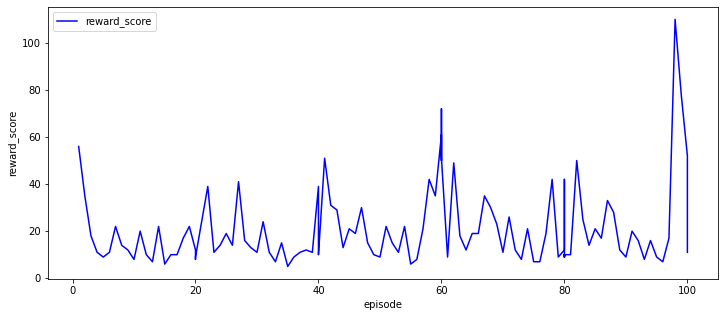

In [27]:
%matplotlib inline
import pandas as pd
import json

training_metrics_file = "training_metrics.json"
training_metrics_path = "{}/{}".format(s3_prefix, training_metrics_file)
wait_for_s3_object(s3_bucket, training_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, training_metrics_file)
with open(json_file) as fp:
    data = json.load(fp)

df = pd.DataFrame(data["metrics"])
x_axis = "episode"
y_axis = "reward_score"

plt = df.plot(x=x_axis, y=y_axis, figsize=(12, 5), legend=True, style="b-")
plt.set_ylabel(y_axis)
plt.set_xlabel(x_axis);

### Upload Your Model into the DeepRacer console

When training is complete, import the trained model into the DeepRacer console so one can clone and train it further in the console, evaluate it in the console, or submit it to the virtual league. Visit <a href="https://us-east-1.console.aws.amazon.com/deepracer/home?region=us-east-1#models">"Your Models"</a> in the DeepRacer console, click the 'Import model' button, and follow the directions. Use the following URL for your import path:

In [28]:
display(Markdown("Copy and paste this S3 path: <a href=\"s3://%s/%s\">s3://%s/%s</a>"%(s3_bucket,s3_prefix,s3_bucket,s3_prefix)))

Copy and paste this S3 path: <a href="s3://sagemaker-us-east-1-011113936377/deepracer-notebook-sagemaker-221115-224306">s3://sagemaker-us-east-1-011113936377/deepracer-notebook-sagemaker-221115-224306</a>

### Clean up RoboMaker and SageMaker training job

Execute the cells below if you want to kill RoboMaker and SageMaker job.

In [29]:
# Cancelling robomaker job
for job_arn in job_arns:
    robomaker.cancel_simulation_job(job=job_arn)

# Stopping sagemaker training job
sage_session.sagemaker_client.stop_training_job(TrainingJobName=job_name)

ClientError: An error occurred (ValidationException) when calling the StopTrainingJob operation: The request was rejected because the training job is in status Stopped.

# Evaluation (Time trail, Object avoidance, Head to bot)

In [44]:
s3_yaml_name = "evaluation_params.yaml"
world_name = "2022_reinvent_champ"

with open("./src/artifacts/yaml/evaluation_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.safe_load(filepointer)

yaml_config["WORLD_NAME"] = world_name
yaml_config["MODEL_S3_BUCKET"] = s3_bucket
yaml_config["MODEL_S3_PREFIX"] = s3_prefix
yaml_config["AWS_REGION"] = aws_region
yaml_config["METRICS_S3_BUCKET"] = s3_bucket
yaml_config["METRICS_S3_OBJECT_KEY"] = "{}/evaluation_metrics.json".format(s3_prefix)
yaml_config["SIMTRACE_S3_BUCKET"] = s3_bucket
yaml_config["SIMTRACE_S3_PREFIX"] = "{}/iteration-data/evaluation".format(s3_prefix)
yaml_config["ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID"] = account_id
yaml_config["NUMBER_OF_TRIALS"] = "5"
yaml_config["MP4_S3_BUCKET"] = s3_bucket
yaml_config["MP4_S3_OBJECT_PREFIX"] = "{}/iteration-data/evaluation".format(s3_prefix)

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config["NUMBER_OF_OBSTACLES"] = "6"
    yaml_config["RACE_TYPE"] = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config["NUMBER_OF_BOT_CARS"] = "6"
    yaml_config["RACE_TYPE"] = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, " "), value))

# Uploading the modified yaml parameter
with open("./evaluation_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml
!rm evaluation_params.yaml

JOB_TYPE                                : EVALUATION
WORLD_NAME                              : 2022_reinvent_champ
MODEL_S3_BUCKET                         : sagemaker-us-east-1-011113936377
MODEL_S3_PREFIX                         : deepracer-notebook-sagemaker-221103-143830
AWS_REGION                              : us-east-1
METRICS_S3_BUCKET                       : sagemaker-us-east-1-011113936377
METRICS_S3_OBJECT_KEY                   : deepracer-notebook-sagemaker-221103-143830/evaluation_metrics.json
SIMTRACE_S3_BUCKET                      : sagemaker-us-east-1-011113936377
SIMTRACE_S3_PREFIX                      : deepracer-notebook-sagemaker-221103-143830/iteration-data/evaluation
NUMBER_OF_TRIALS                        : 5
ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID     : 011113936377
CAR_COLOR                               : Grey
NUMBER_OF_RESETS                        : 10000
PENALTY_SECONDS                         : 2.0
IS_CONTINUOUS                           : false
OFF_TRACK_PENAL

In [45]:
responses = list()
for job_no in range(num_simulation_workers):
    response = robomaker.create_simulation_job(
        clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
        outputLocation={
            "s3Bucket": s3_bucket,
            "s3Prefix": s3_prefix
        },
        maxJobDurationInSeconds=job_duration_in_seconds,
        iamRole=sagemaker_role,
        failureBehavior="Fail",
        simulationApplications=[{
            "application": simulation_app_arn,
            "applicationVersion": "$LATEST",
            "launchConfig": {
                "command": ["roslaunch", "deepracer_simulation_environment", "evaluation.launch"],
                "environmentVariables": {
                    "S3_YAML_NAME": s3_yaml_name,
                    "MODEL_S3_PREFIX": s3_prefix,
                    "MODEL_S3_BUCKET": s3_bucket,
                    "WORLD_NAME": world_name,
                    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
                    "APP_REGION": aws_region,
                    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix,
                },
                "streamUI": True
            },
            "uploadConfigurations": [{
                    "name": "gazebo-logs",
                    "path": "/root/.gazebo/server*/*.log",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                },
                {
                    "name": "ros-logs",
                    "path": "/root/.ros/log/**",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                }
            ],
            "useDefaultUploadConfigurations": False,
            "tools": [{
                "streamUI": True,
                "name": "rviz",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; rviz",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "terminal",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; xfce4-terminal",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "gazebo",
                "command": "source /opt/ml/code/scripts/gzclient_source.sh; export GAZEBO_MODEL_PATH=/opt/amazon/install/deepracer_simulation_environment/share/deepracer_simulation_environment/; gzclient",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
            }],
        }],
        vpcConfig={
            "subnets": deepracer_subnets,
            "securityGroups": deepracer_security_groups,
            "assignPublicIp": True
        }
    )
    responses.append(response)
    time.sleep(5)
    
print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

Created the following jobs:
Job ARN arn:aws:robomaker:us-east-1:011113936377:simulation-job/sim-txfzfbndkn2c


### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [46]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

> Click on the following links for visualization of simulation jobs on RoboMaker Console
- [Simulation 1](https://us-east-1.console.aws.amazon.com/robomaker/home?region=us-east-1#simulationJobs/sim-txfzfbndkn2c)  

You can click on Gazebo after you open the above link to start the simulator.

### Creating temporary folder top plot metrics

In [48]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:
    data = json.load(fp)

df = pd.DataFrame(data["metrics"])
# Converting milliseconds to seconds
df["elapsed_time"] = df["elapsed_time_in_milliseconds"] / 1000
df = df[["trial", "completion_percentage", "elapsed_time"]]

display(df)

Waiting for s3://sagemaker-us-east-1-011113936377/deepracer-notebook-sagemaker-221103-143830/evaluation_metrics.json...


,trial,completion_percentage,elapsed_time
0,1,100,38.585
1,2,100,39.335
2,3,100,36.942
3,4,100,36.531
4,5,100,37.523


### Clean Up Simulation Application Resource

In [ ]:
# Do not run this command unless you want to delete your simulation application resource
robomaker.delete_simulation_application(application=simulation_app_arn)

### Clean your S3 bucket (Uncomment the awscli commands if you want to do it)

In [ ]:
## Uncomment if you only want to clean the s3 bucket
# sagemaker_s3_folder = "s3://{}/{}".format(s3_bucket, s3_prefix)
# !aws s3 rm --recursive {sagemaker_s3_folder}

# robomaker_s3_folder = "s3://{}/{}".format(s3_bucket, job_name)
# !aws s3 rm --recursive {robomaker_s3_folder}

# robomaker_sim_app = "s3://{}/{}".format(s3_bucket, 'robomaker')
# !aws s3 rm --recursive {robomaker_sim_app}

# model_output = "s3://{}/{}".format(s3_bucket, s3_bucket)
# !aws s3 rm --recursive {model_output}

# Head-to-head Evaluation

In [ ]:
# S3 bucket
s3_bucket_2 = sage_session.default_bucket()

# Ensure that the S3 prefix contains the keyword 'sagemaker'
# e.g."deepracer-notebook-sagemaker-200422-231836"
# Please provide the second agents s3_prefix
s3_prefix_2 = "[FILL OUT PREFIX]"

if not s3_prefix_2:
    raise Exception(
        "Please provide the second agents s3_prefix and s3_bucket. The prefix would have sagemaker in between"
    )

print("Using s3 bucket {}".format(s3_bucket_2))
print(
    "Model checkpoints and other metadata will be stored at: \ns3://{}/{}".format(
        s3_bucket_2, s3_prefix_2
    )
)

In [ ]:
s3_yaml_name = "evaluation_params.yaml"
world_name = "2022_reinvent_champ"

with open("./src/artifacts/yaml/head2head_yaml_template.yaml", "r") as filepointer:
    yaml_config = yaml.safe_load(filepointer)

yaml_config["WORLD_NAME"] = world_name
yaml_config["MODEL_S3_BUCKET"] = [s3_bucket, s3_bucket_2]
yaml_config["MODEL_S3_PREFIX"] = [s3_prefix, s3_prefix_2]
yaml_config["MODEL_METADATA_FILE_S3_KEY"] = [
    "{}/model/model_metadata.json".format(s3_prefix),
    "{}/model/model_metadata.json".format(s3_prefix_2),
]
yaml_config["AWS_REGION"] = aws_region
yaml_config["METRICS_S3_BUCKET"] = [s3_bucket, s3_bucket_2]
yaml_config["METRICS_S3_OBJECT_KEY"] = [
    "{}/evaluation_metrics.json".format(s3_prefix),
    "{}/evaluation_metrics.json".format(s3_prefix_2),
]
yaml_config["SIMTRACE_S3_BUCKET"] = [s3_bucket, s3_bucket_2]
yaml_config["SIMTRACE_S3_PREFIX"] = [
    "{}/iteration-data/evaluation".format(s3_prefix),
    "{}/iteration-data/evaluation".format(s3_prefix_2),
]
yaml_config["ROBOMAKER_SIMULATION_JOB_ACCOUNT_ID"] = account_id
yaml_config["NUMBER_OF_TRIALS"] = "5"
yaml_config["MP4_S3_BUCKET"] = [s3_bucket, s3_bucket_2]
yaml_config["MP4_S3_OBJECT_PREFIX"] = [
    "{}/iteration-data/evaluation".format(s3_prefix),
    "{}/iteration-data/evaluation".format(s3_prefix_2),
]

# Race-type supported for training are TIME_TRIAL, OBJECT_AVOIDANCE, HEAD_TO_BOT
# If you need to modify more attributes look at the template yaml file
race_type = "TIME_TRIAL"

if race_type == "OBJECT_AVOIDANCE":
    yaml_config["NUMBER_OF_OBSTACLES"] = "6"
    yaml_config["RACE_TYPE"] = "OBJECT_AVOIDANCE"

elif race_type == "HEAD_TO_BOT":
    yaml_config["NUMBER_OF_BOT_CARS"] = "6"
    yaml_config["RACE_TYPE"] = "HEAD_TO_BOT"

# Printing the modified yaml parameter
for key, value in yaml_config.items():
    print("{}: {}".format(key.ljust(40, " "), value))

# Uploading the modified yaml parameter
with open("./evaluation_params.yaml", "w") as filepointer:
    yaml.dump(yaml_config, filepointer)

!aws s3 cp ./evaluation_params.yaml {s3_location}/evaluation_params.yaml
!rm evaluation_params.yaml

In [ ]:
responses = list()
for job_no in range(num_simulation_workers):
    response = robomaker.create_simulation_job(
        clientRequestToken=strftime("%Y-%m-%d-%H-%M-%S", gmtime()),
        outputLocation={
            "s3Bucket": s3_bucket,
            "s3Prefix": s3_prefix
        },
        maxJobDurationInSeconds=job_duration_in_seconds,
        iamRole=sagemaker_role,
        failureBehavior="Fail",
        simulationApplications=[{
            "application": simulation_app_arn,
            "applicationVersion": "$LATEST",
            "launchConfig": {
                "command": ["roslaunch", "deepracer_simulation_environment", "evaluation.launch"],
                "environmentVariables": {
                    "S3_YAML_NAME": s3_yaml_name,
                    "MODEL_S3_PREFIX": s3_prefix,
                    "MODEL_S3_BUCKET": s3_bucket,
                    "WORLD_NAME": world_name,
                    "KINESIS_VIDEO_STREAM_NAME": kvs_stream_name,
                    "APP_REGION": aws_region,
                    "MODEL_METADATA_FILE_S3_KEY": "%s/model/model_metadata.json" % s3_prefix,
                },
                "streamUI": True
            },
            "uploadConfigurations": [{
                    "name": "gazebo-logs",
                    "path": "/root/.gazebo/server*/*.log",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                },
                {
                    "name": "ros-logs",
                    "path": "/root/.ros/log/**",
                    "uploadBehavior": "UPLOAD_ON_TERMINATE"
                }
            ],
            "useDefaultUploadConfigurations": False,
            "tools": [{
                "streamUI": True,
                "name": "rviz",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; rviz",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "terminal",
                "command": "source /opt/ros/melodic/setup.bash;source /opt/amazon/install/setup.bash; xfce4-terminal",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
              },
              {
                "streamUI": True,
                "name": "gazebo",
                "command": "source /opt/ml/code/scripts/gzclient_source.sh; export GAZEBO_MODEL_PATH=/opt/amazon/install/deepracer_simulation_environment/share/deepracer_simulation_environment/; gzclient",
                "streamOutputToCloudWatch": True,
                "exitBehavior": "RESTART"
            }],
        }],
        vpcConfig={
            "subnets": deepracer_subnets,
            "securityGroups": deepracer_security_groups,
            "assignPublicIp": True
        }
    )
    responses.append(response)
    time.sleep(5)
    
print("Created the following jobs:")
job_arns = [response["arn"] for response in responses]
for job_arn in job_arns:
    print("Job ARN", job_arn)

### Visualizing the simulations in RoboMaker
You can visit the RoboMaker console to visualize the simulations or run the following cell to generate the hyperlinks.

In [ ]:
display(Markdown(generate_robomaker_links(job_arns, aws_region)))

### Creating temporary folder top plot metrics

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix, evaluation_metrics_file)
wait_for_s3_object(s3_bucket, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:
    data = json.load(fp)

df_1 = pd.DataFrame(data["metrics"])
# Converting milliseconds to seconds
df_1["elapsed_time"] = df_1["elapsed_time_in_milliseconds"] / 1000
df_1 = df_1[["trial", "completion_percentage", "elapsed_time"]]

display(df_1)

In [ ]:
evaluation_metrics_file = "evaluation_metrics.json"
evaluation_metrics_path = "{}/{}".format(s3_prefix_2, evaluation_metrics_file)
wait_for_s3_object(s3_bucket_2, evaluation_metrics_path, tmp_dir)

json_file = "{}/{}".format(tmp_dir, evaluation_metrics_file)
with open(json_file) as fp:
    data = json.load(fp)

df_2 = pd.DataFrame(data["metrics"])
# Converting milliseconds to seconds
df_2["elapsed_time"] = df_2["elapsed_time_in_milliseconds"] / 1000
df_2 = df_2[["trial", "completion_percentage", "elapsed_time"]]

display(df_2)

### Clean Up Simulation Application Resource

In [33]:
robomaker.delete_simulation_application(application=simulation_app_arn)

{'ResponseMetadata': {'RequestId': '5fda7f85-a9b4-46b3-b538-5fc478d20eda',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Wed, 02 Nov 2022 16:10:28 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '5fda7f85-a9b4-46b3-b538-5fc478d20eda',
   'access-control-allow-origin': '*',
   'access-control-allow-headers': 'Content-Type,X-Amz-Date,Authorization,X-Api-Key,X-Amz-Security-Token',
   'x-amz-apigw-id': 'a-xyPGAmIAMFx1g=',
   'access-control-allow-methods': 'GET,OPTIONS,POST',
   'access-control-expose-headers': 'x-amzn-RequestId,x-amzn-ErrorType',
   'x-amzn-trace-id': 'Root=1-63629674-6c864b1f07168747005f0017'},
  'RetryAttempts': 0}}

### Clean your S3 bucket (Uncomment the awscli commands if you want to do it)

In [ ]:
## Uncomment if you only want to clean the s3 bucket
# sagemaker_s3_folder = "s3://{}/{}".format(s3_bucket, s3_prefix)
# !aws s3 rm --recursive {sagemaker_s3_folder}

# robomaker_s3_folder = "s3://{}/{}".format(s3_bucket, job_name)
# !aws s3 rm --recursive {robomaker_s3_folder}

# robomaker_sim_app = "s3://{}/{}".format(s3_bucket, 'robomaker')
# !aws s3 rm --recursive {robomaker_sim_app}

# model_output = "s3://{}/{}".format(s3_bucket, s3_bucket)
# !aws s3 rm --recursive {model_output}